## DEMO: H wavefunctions

#### Requirements | Importing libraries

In [4]:
import matplotlib, matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.special import sph_harm
from scipy.constants import physical_constants
from matplotlib import cm, colors
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    from google.colab import output
    output.enable_custom_widget_manager()
    print('All good to go')
except:
    print('Okay we are not in Colab just proceed as if nothing happened')

Okay we are not in Colab just proceed as if nothing happened


#### 1. Describing a radial function $R_{nl}(r)$

$$R_{nl} = \sqrt{ \Big( \frac{2}{n a_0} \Big)^3 \frac{(n-l-1)!}{2n(n+l)!}} \cdot e^{-\frac{r}{n a_0}} \cdot \Big( \frac{2 r}{n a_0} \Big)^l \cdot L^{2l+1}_{n-l-1}\Big( \frac{2 r}{n a_0} \Big)$$

In [2]:
def radial_function(r, 
                    n=1, 
                    l=0):
    '''Rnl(r) normalized radial function
    r: radial distance Float (0, inf)
    n: principal quantum number Int (1,2,3... inf)
    l: angular quantum number Int (0,1,2,... n-1)
    '''

    a0 = 1 # Bohr radius equal to 5.29e-11 m

    prefactor = np.sqrt( ((2 / n * a0) ** 3 * (np.math.factorial(n - l - 1))) / (2 * n * (np.math.factorial(n + l))) )

    laguerre = sp.genlaguerre(n - l - 1, 2 * l + 1)

    p = 2 * r / (n * a0)
    

    return  prefactor * np.exp(-p / 2) * (p ** l) * laguerre(p)

/tmp/ipykernel_2849/2304368228.py:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prefactor = np.sqrt( ((2 / n * a0) ** 3 * (np.math.factorial(n - l - 1))) / (2 * n * (np.math.factorial(n + l))) )


Text(0, 0.5, '$R_nl(r) r^2$')

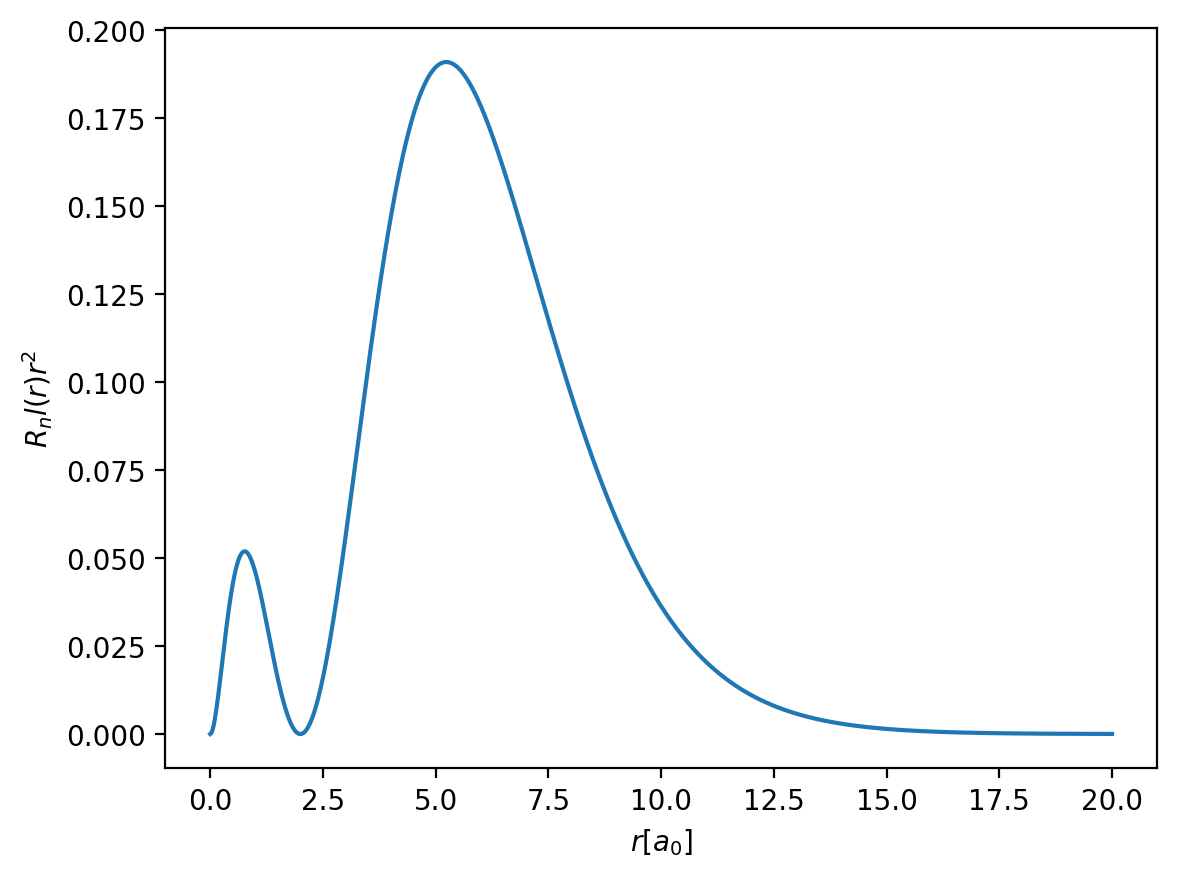

In [3]:
r = np.linspace(0, 20, 1000)

Rnl = radial_function(r, n=2, l=0)

#plt.plot(r, Rnl)
#plt.plot(r, Rnl**2)
plt.plot(r, r**2 * Rnl**2)
plt.xlabel(r'$r [a_0]$')
plt.ylabel(r'$R_nl(r) r^2$')

#### 2. Describing an angular function | Spherical harmonic $Y_{l}^{m}(\theta, \varphi)$

- We will make use of [sph_harm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.sph_harm.html#scipy.special.sph_harm) function from Scipy
- We can also build up spherical harmonics using Associated Legendre function using [lpvm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.lpmv.html#scipy.special.lpmv) 

$$
Y_{lm}(\phi,\theta) = \sqrt{\frac{2l+1}{4\pi} \frac{(l-m)!}{(l+m)!} } P_{lm}(cos \phi) \cdot e^{im\theta}
$$

In [16]:
sph_harm(0, 0, np.pi, np.pi) # test a few spherical harmonics

(0.28209479177387814+0j)

In [54]:
def plot_Yml(l, m):
    '''Visualizing spherical harmonics using sph_harm funcion from Scipy special function library
     Note that the name of angles is different from the notation adopted in QM textbooks!
     l: angular quantum number (0,1,2,...)
     m: magnetic quantum number (-l,...l)
     '''

    #Creade grid of phi and theta angles for ploting surface mesh
    phi, theta = np.linspace(0, np.pi, 100), np.linspace(0, 2*np.pi, 100)
    phi, theta = np.meshgrid(phi, theta)

    #Calcualte spherical harmonic with given m and l
    Ylm = sph_harm(m, l, theta, phi ) 
    R=abs(Ylm)
    
    # Let's normalize color scale
    fcolors = Ylm.real
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors - fmin)/(fmax - fmin)

    # Since we want to plot on cartesian reference frame we will use cartesian coordiniates x, y, z using R as the absolute value of Yml
    # Try a plot without R part. 
    fig = go.Figure(data=[go.Surface(x=R*np.sin(phi) * np.cos(theta), 
                                     y=R*np.sin(phi) * np.sin(theta), 
                                     z=R*np.cos(phi), 
                                     surfacecolor=fcolors,
                                     colorscale='balance')])

    # Show the plot
    fig.update_layout(title=r'$Y_{l, m}$', autosize=False,
                      width=700, height=700,
                      margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

In [55]:
plot_Yml(l=1, m=0)

#### 3. Describing the normalized probability as wavefunction squared $|\psi _{nlm}(r,\theta ,\varphi)|^2$ 

$$\psi_{nlm} = R_{nl}(r) \cdot Y_{l}^{m}(\theta, \varphi)$$

In [56]:
def normalized_wavefunction(n, 
                            l, 
                            m):

    '''Ψnlm(r,θ,φ) normalized wavefunction
    by definition of quantum numbers n, l, m and a bohr radius augmentation coefficient'''

    # Set coordinates grid to assign a certain probability to each point (x, y) in the plane
    x = y = np.linspace(-20, 20, 1000)
    x, y = np.meshgrid(x, y)
    r = np.sqrt((x ** 2 + y ** 2))

    # Ψnlm(r,θ,φ) = Rnl(r).Ylm(θ,φ)
    psi = radial_function(r, n, l) * sph_harm(m, l, np.arctan(x / (y + 1e-10)), 0)

    return np.abs(psi) ** 2

#### 4. Plotting wavefunction electron probability density plots

In [60]:
def plot_wavefunction(n, 
                      l, 
                      m):

    fig, ax = plt.subplots()
    im = ax.imshow(np.sqrt(normalized_wavefunction(n, l, m)), cmap='rocket')

    # Add colorbar
    cbar = plt.colorbar(im, fraction=0.046, pad=0.09)
    cbar.set_ticks([])

    # Apply dark palette 
    fig.patch.set_facecolor('#020419'); cbar.outline.set_visible(False)
    plt.rcParams['text.color']='#dfdfdf'; ax.tick_params(axis='x', colors='#c4c4c4')
    ax.tick_params(axis='y', colors='#c4c4c4')

    ax.spines['top'].set_color('#020419'); ax.spines['right'].set_color('#020419')
    ax.spines['bottom'].set_color('#c4c4c4'); ax.spines['left'].set_color('#c4c4c4')
    ax.set_title(r'$\psi_{{({0}, {1}, {2})}}$'.format(n, l, m), pad=20, fontsize=15, color='#dfdfdf')

    # Add text and labels
    ax.invert_yaxis()

    # Save plot
    #plt.savefig(f'wavefunction ({n},{l},{m}).png', dpi=245, bbox_inches='tight', pad_inches=0.3)

###  Implementation | Output:

Light shaded areas in the orbital cross-sections represent a high probability of a particle being present in that region.

/tmp/ipykernel_2849/2304368228.py:12: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`



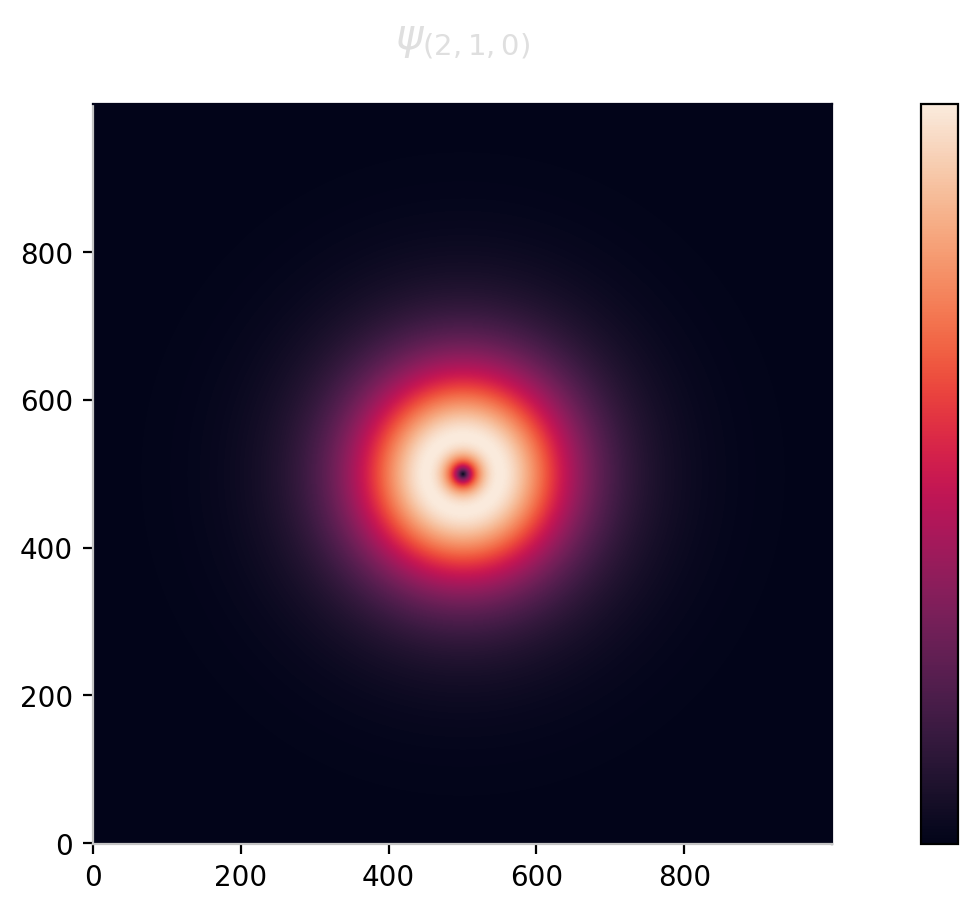

In [73]:
plot_wavefunction(n=2, 
                  l=1, 
                  m=0)  